In [13]:
import pandas as pd

# List of file paths
file_paths = [
    'C:/Users/lauri/PycharmProjects/test_project_LNU/data/precip_climap/Niederschlag_1997.csv',
    'C:/Users/lauri/PycharmProjects/test_project_LNU/data/precip_climap/Niederschlag_2023.csv'
]

def process_file(file_path):
    # Read the data
    df = pd.read_csv(file_path, sep=';', header=0)  # Set separator to semicolon

    # Remove whitespace from column names
    df.columns = df.columns.str.strip()

    # Ensure that the relevant columns have the correct data types
    if 'JAHR' in df.columns:
        df['JAHR'] = df['JAHR'].astype(int)
    if 'MO' in df.columns:
        df['MO'] = df['MO'].astype(int)
    if 'TG' in df.columns:
        df['TG'] = df['TG'].astype(int)

    return df

# Process the data
df_1997 = process_file(file_paths[0])
df_2023 = process_file(file_paths[1])

# Remove rows with value 32767 in the last column
df_1997_cleaned = df_1997[df_1997.iloc[:, -1] != 32767]
df_2023_cleaned = df_2023[df_2023.iloc[:, -1] != 32767]

# Get the unique station numbers from both years
stations_1997 = set(df_1997_cleaned['STA'])
stations_2023 = set(df_2023_cleaned['STA'])

# Find common stations
common_stations = list(stations_1997.intersection(stations_2023))

# Output the common stations and their count
print("Common station numbers (STA) in the years 1997 and 2023:")
print(common_stations)

# Count of unique common stations
number_of_common_stations = len(common_stations)
print(f"\nNumber of common stations: {number_of_common_stations}")


Common station numbers (STA) in the years 1997 and 2023:
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 95, 96, 97, 98, 103, 104, 105, 106, 113, 116, 117, 118, 120, 123, 124, 127, 129, 131, 140, 141, 143, 148, 151, 152, 153, 154, 155, 156, 157, 159, 161, 162, 165, 167, 172, 175, 177, 178, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 196, 198, 204, 205, 206, 211, 215, 219, 224, 228, 229, 230, 231, 233, 236, 237, 239, 240, 242, 243, 244, 246, 247, 248, 249, 254, 255, 256, 257, 259, 262, 266, 270, 272, 274, 276, 279, 280, 281, 286, 290, 294, 296, 297, 298, 299, 301, 302, 304, 306, 307, 308, 309, 311, 313, 316, 317, 318, 319, 320, 321, 324, 326, 327, 328, 330, 332, 336, 338, 341, 342, 343, 344, 350, 352, 355

In [14]:
import pandas as pd
import xarray as xr
import numpy as np

# Pfad zur CSV-Datei
file_path = "N:/gebhyd/3_Hyv/Diplomanden/2_Running/L_Nuesch/P_Data_reshape/P_Stationen.csv"

# CSV-Datei einlesen mit Semikolon als Trennzeichen
df = pd.read_csv(file_path, sep=';', header=None)
df = df[df[0].isin(common_stations)]

# Überprüfen der geladenen Daten
#print("Geladene Daten:")
#print(df.head())
# Gefilterten DataFrame als CSV speichern
#df.to_csv('../CH_data/preprocessed_P_data/P_Stationen_filltered.csv', sep=';', index=False, header=False)


# Die Anzahl der Spalten prüfen
print(f"Anzahl der Spalten: {df.shape[1]}")

# Die Spalten umbenennen, wenn die richtige Anzahl an Spalten vorhanden ist
if df.shape[1] == 6:
    df.columns = ['STA', 'Name', 'Elevation', 'Unit', 'Lon', 'Lat']
    # Umrechnung von LV03 nach LV95
    df['Lon'] = df['Lon'] + 2000000
    df['Lat'] = df['Lat'] + 1000000
else:
    raise ValueError(f"Unerwartete Anzahl von Spalten: {df.shape[1]}")


df.to_csv('../CH_data/preprocessed_P_data/P_Stationen_filltered.csv', sep=';', index=False, header=False)
# Station Metadata extrahieren und vorbereiten
stations = {}
for _, row in df.iterrows():
    station_id = int(row['STA'])
    station_name = row['Name']
    elevation = int(row['Elevation'])
    lon = float(row['Lon'])  # Longitude aus der DataFrame nehmen
    lat = float(row['Lat'])   # Latitude aus der DataFrame nehmen
    stations[station_id] = {
        'name': station_name,
        'elevation': elevation,
        'longitude': lon,
        'latitude': lat
    }

# Erstellen des xarray Datasets
# Erstellen der DataArrays für LLE
lle_data = xr.DataArray(
    np.array([[station['longitude'], station['latitude'], station['elevation']] for station in stations.values()]),
    dims=['station', 'lle'],  # Ändern der Dimension von 'LLE' zu 'lle'
    coords={
        'station': list(stations.keys()),
        'lle': ['lon', 'lat', 'elev']  # Korrigierte Koordinatenbenennung
    }
)

# Leere DataArray für Niederschlag und Datum erstellen
# Angenommen, dass wir später nday Daten hinzufügen werden
nday = 0  # Aktuell keine Daten, kann später aktualisiert werden
# Hier initialisieren wir nday als leeres Array für zukünftige Zeitstempel
nday_coords = np.array([], dtype='datetime64[ns]')  # Leeres Array für nday-Koordinaten
precipitation = xr.DataArray(
    np.full((nday, len(stations)), np.nan),  # Leeres Array für Niederschlag
    dims=['nday', 'station'],  # Ändern der Dimension von 'date' zu 'nday'
    coords={
        'nday': nday_coords,  # Leeres Koordinaten-Array für nday
        'station': list(stations.keys())
    }
)

# Erstellen des finalen Datasets
ds = xr.Dataset(
    {
        'LLE': lle_data,  # Die Variable bleibt als 'LLE'
        'precipitation': precipitation
    }
)

# Hinzufügen der Stationen zu den Attributen
for station_id, metadata in stations.items():
    ds.attrs[f'station_{station_id}'] = {
        'name': metadata['name'],
        'elevation': metadata['elevation'],
        'longitude': metadata['longitude'],
        'latitude': metadata['latitude']
    }

# Ausgabe des Datasets
p_data_xarray = ds
print(p_data_xarray)


Anzahl der Spalten: 6
<xarray.Dataset>
Dimensions:        (lle: 3, nday: 0, station: 404)
Coordinates:
  * station        (station) int32 54 338 630 405 409 73 ... 578 593 607 609 818
  * lle            (lle) <U4 'lon' 'lat' 'elev'
  * nday           (nday) datetime64[ns] 
Data variables:
    LLE            (station, lle) float64 2.708e+06 1.174e+06 ... 1.248e+03
    precipitation  (nday, station) float64 
Attributes:
    station_54:   {'name': 'Disentis / Sedrun', 'elevation': 1197, 'longitude...
    station_338:  {'name': 'Vals', 'elevation': 1242, 'longitude': 2734016.0,...
    station_630:  {'name': 'Ilanz', 'elevation': 698, 'longitude': 2735685.0,...
    station_405:  {'name': 'Andeer', 'elevation': 987, 'longitude': 2752687.0...
    station_409:  {'name': 'Bivio', 'elevation': 1856, 'longitude': 2771282.0...
    station_73:   {'name': 'Weissfluhjoch', 'elevation': 2691, 'longitude': 2...
    station_26:   {'name': 'Davos', 'elevation': 1594, 'longitude': 2783514.0...
    station

In [15]:
"""
import pandas as pd

# Pfad zur .dat-Datei
file_path = "N:/gebhyd/3_Hyv/Diplomanden/2_Running/L_Nuesch/P_Data_reshape/rawdata/P_1998.dat"

# Datei zuerst manuell zeilenweise einlesen, um die Startzeile zu finden
with open(file_path, 'r') as file:
    lines = file.readlines()

# Finde die Zeile, die den Header enthält
start_line = 0
for i, line in enumerate(lines):
    if 'STA JAHR MO TG HH MM' in line:
        start_line = i
        break

# Lade nur die Daten ab der Zeile des Headers
df = pd.read_csv(file_path, sep='\s+', skiprows=start_line + 1, header=None)

# Die Spalten umbenennen
df.columns = ['STA', 'JAHR', 'MO', 'TG', 'HH', 'MM', '236']

# Optional: Um "32767" (vermutlich ein Fehldatenwert) in NaN umwandeln
df['236'].replace(32767, float('nan'), inplace=True)

# Pandas Anzeigeoptionen für ein besseres Layout
pd.set_option('display.float_format', '{:.2f}'.format)  # Zahlenformatierung auf 2 Dezimalstellen
pd.set_option('display.max_columns', None)  # Zeige alle Spalten

# Ausgabe anzeigen
print(df.head(10))  # Zeige die ersten 10 Zeilen an
"""


'\nimport pandas as pd\n\n# Pfad zur .dat-Datei\nfile_path = "N:/gebhyd/3_Hyv/Diplomanden/2_Running/L_Nuesch/P_Data_reshape/rawdata/P_1998.dat"\n\n# Datei zuerst manuell zeilenweise einlesen, um die Startzeile zu finden\nwith open(file_path, \'r\') as file:\n    lines = file.readlines()\n\n# Finde die Zeile, die den Header enthält\nstart_line = 0\nfor i, line in enumerate(lines):\n    if \'STA JAHR MO TG HH MM\' in line:\n        start_line = i\n        break\n\n# Lade nur die Daten ab der Zeile des Headers\ndf = pd.read_csv(file_path, sep=\'\\s+\', skiprows=start_line + 1, header=None)\n\n# Die Spalten umbenennen\ndf.columns = [\'STA\', \'JAHR\', \'MO\', \'TG\', \'HH\', \'MM\', \'236\']\n\n# Optional: Um "32767" (vermutlich ein Fehldatenwert) in NaN umwandeln\ndf[\'236\'].replace(32767, float(\'nan\'), inplace=True)\n\n# Pandas Anzeigeoptionen für ein besseres Layout\npd.set_option(\'display.float_format\', \'{:.2f}\'.format)  # Zahlenformatierung auf 2 Dezimalstellen\npd.set_option(\

In [16]:
import pandas as pd
import os

# Pfad zu dem Verzeichnis, das die .dat-Dateien enthält
directory_path = "N:/gebhyd/3_Hyv/Diplomanden/2_Running/L_Nuesch/P_Data_reshape/rawdata/"

# Leerer DataFrame, um alle Daten zu speichern
combined_df = pd.DataFrame()

# Liste aller Jahre, für die Dateien existieren (z.B. 1998 bis 2023)
years = range(1997,2025)

# Schleife über jedes Jahr
for year in years:
    file_path = os.path.join(directory_path, f'P_{year}.dat')
    print 

    # Datei zuerst manuell zeilenweise einlesen, um die Startzeile zu finden
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Finde die Zeile, die den Header enthält
    start_line = 0
    for i, line in enumerate(lines):
        if 'STA JAHR MO TG HH MM' in line:
            start_line = i
            break

    # Lade nur die Daten ab der Zeile des Headers
    df = pd.read_csv(file_path, sep='\s+', skiprows=start_line + 1, header=None)

    # Die Spalten umbenennen
    df.columns = ['STA', 'JAHR', 'MO', 'TG', 'HH', 'MM', '236']
    
    # Filtere nur die Zeilen, die in `common_stations` vorkommen
    df = df[df['STA'].isin(common_stations)]

    # Optional: Um "32767" (vermutlich ein Fehldatenwert) in NaN umwandeln
    df['236'].replace(32767, float('nan'), inplace=True)

    # Füge die Daten zum kombinierten DataFrame hinzu
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Duplikate entfernen basierend auf relevanten Spalten
combined_df.drop_duplicates(subset=['STA', 'JAHR', 'MO', 'TG', 'HH', 'MM'], inplace=True)

# Optional: Sortiere die Daten nach Datum und Uhrzeit
#combined_df.sort_values(by=['STA', 'JAHR', 'MO', 'TG', 'HH', 'MM'], inplace=True)

# Pandas Anzeigeoptionen für ein besseres Layout
pd.set_option('display.float_format', '{:.2f}'.format)  # Zahlenformatierung auf 2 Dezimalstellen
pd.set_option('display.max_columns', None)  # Zeige alle Spalten

# Ausgabe der ersten Zeilen der kombinierten Daten
print(combined_df.head(10))  # Zeige die ersten 10 Zeilen an

print(f"Anzahl der Zeilen im kombinierten DataFrame: {combined_df.shape[0]}")

# Optional: Kombinierte Daten als CSV speichern
combined_df.to_csv('../CH_data/preprocessed_P_data/P_combined_1998_2023.csv', sep=';', index=False)


   STA  JAHR  MO  TG  HH  MM  236
0   54  1996  10   1   8  50  nan
1   54  1996  10   2   0   0 1.40
2   54  1996  10   3   0   0 0.00
3   54  1996  10   4   0   0 0.00
4   54  1996  10   5   0   0 6.20
5   54  1996  10   6   0   0 0.00
6   54  1996  10   7   0   0 0.00
7   54  1996  10   8   0   0 0.20
8   54  1996  10   9   0   0 0.10
9   54  1996  10  10   0   0 3.30
Anzahl der Zeilen im kombinierten DataFrame: 4143020


In [17]:
# Schritt 1: Erstelle nday-Koordinaten aus dem combined_df
combined_df['nday'] = pd.to_datetime(combined_df[['JAHR', 'MO', 'TG']].astype(str).agg('-'.join, axis=1))

# Schritt 2: Eindeutige nday-Werte extrahieren
nday_values = combined_df['nday'].unique()

# Schritt 3: Entferne die alte 'precipitation' Variable, da sie die falsche Dimension hat
p_data_xarray = p_data_xarray.drop_vars('precipitation')

# Schritt 4: Setze nday-Koordinaten im Dataset
p_data_xarray = p_data_xarray.assign_coords(nday=nday_values)

# Schritt 5: Initialisiere das DataArray für precipitation mit der richtigen Form
p_data_xarray['precipitation'] = xr.DataArray(
    np.full((len(nday_values), len(p_data_xarray['station'])), np.nan),  # Leeres Array für Niederschlag
    dims=['nday', 'station'],
    coords={
        'nday': nday_values,
        'station': p_data_xarray['station']
    }
)
print(p_data_xarray)



<xarray.Dataset>
Dimensions:        (lle: 3, nday: 10228, station: 404)
Coordinates:
  * station        (station) int32 54 338 630 405 409 73 ... 578 593 607 609 818
  * lle            (lle) <U4 'lon' 'lat' 'elev'
  * nday           (nday) datetime64[ns] 1996-10-01 1996-10-02 ... 2024-10-01
Data variables:
    LLE            (station, lle) float64 2.708e+06 1.174e+06 ... 1.248e+03
    precipitation  (nday, station) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    station_54:   {'name': 'Disentis / Sedrun', 'elevation': 1197, 'longitude...
    station_338:  {'name': 'Vals', 'elevation': 1242, 'longitude': 2734016.0,...
    station_630:  {'name': 'Ilanz', 'elevation': 698, 'longitude': 2735685.0,...
    station_405:  {'name': 'Andeer', 'elevation': 987, 'longitude': 2752687.0...
    station_409:  {'name': 'Bivio', 'elevation': 1856, 'longitude': 2771282.0...
    station_73:   {'name': 'Weissfluhjoch', 'elevation': 2691, 'longitude': 2...
    station_26:   {'name': 'Davos', 'el

TypeError: Invalid value for attr: {'name': 'Disentis / Sedrun', 'elevation': 1197, 'longitude': 2708189.0, 'latitude': 1173789.0} must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files

In [20]:
# Speichern ohne die station_X Attribute
cleaned_attrs = {k: v for k, v in p_data_xarray.attrs.items() if not isinstance(v, dict)}
p_data_xarray.attrs = cleaned_attrs

# Speichere das Dataset als NetCDF
p_data_xarray.to_netcdf('../CH_data/CH_input_data/p_data_xarray.nc')

In [16]:
import pandas as pd
import xarray as xr
import numpy as np

# Schritt 1: Daten einlesen
# P_Stationen_filltered.csv einlesen
stations_df = pd.read_csv('../CH_data/preprocessed_P_data/P_Stationen_filltered.csv', sep=';', header=None)
stations_df.columns = ['STA', 'Name', 'unknown1', 'unknown2', 'lon', 'lat']

# P_combined_1998_2023.csv einlesen
combined_df = pd.read_csv('../CH_data/preprocessed_P_data/P_combined_1998_2023.csv', sep=';')

# Schritt 2: Nday und Precipitation Daten erstellen
# Erstelle eine nday Spalte
combined_df['nday'] = pd.to_datetime(combined_df[['JAHR', 'MO', 'TG']].astype(str).agg('-'.join, axis=1))

# Extrahiere die benötigten Daten für Precipitation
precipitation_data = combined_df.pivot_table(index='nday', columns='STA', values='236', aggfunc='first')

# Schritt 3: xarray Dataset erstellen
# Erstelle die Koordinaten für das Dataset
stations = stations_df['STA'].unique()
lon = stations_df['lon'].values
lat = stations_df['lat'].values
elev = np.zeros_like(stations)  # Dummy-Werte für Elevation
lle = ['lon', 'lat', 'elev']

# Erstelle das Dataset
ds = xr.Dataset(
    {
        'LLE': (('station', 'lle'), np.column_stack([lon, lat, elev])),
        'precipitation': (('nday', 'station'), precipitation_data.values),
    },
    coords={
        'station': ('station', stations),
        'nday': ('nday', precipitation_data.index),
        'lle': lle,
    },
)

# Schritt 4: Werte für LLE hinzufügen
for i, station in enumerate(stations):
    ds['LLE'][i, 0] = lon[i]  # longitude
    ds['LLE'][i, 1] = lat[i]  # latitude
    ds['LLE'][i, 2] = elev[i]  # elevation (hier als Dummy-Wert, falls benötigt)

# Optional: Überprüfung des Datasets
print(ds)


<xarray.Dataset>
Dimensions:        (lle: 3, nday: 10227, station: 404)
Coordinates:
  * station        (station) int64 54 338 630 405 409 73 ... 578 593 607 609 818
  * nday           (nday) datetime64[ns] 1996-10-02 1996-10-03 ... 2024-10-01
  * lle            (lle) <U4 'lon' 'lat' 'elev'
Data variables:
    LLE            (station, lle) int64 2708189 1173789 0 ... 2831170 1169340 0
    precipitation  (nday, station) float64 7.2 8.0 2.8 5.4 ... 53.0 44.9 41.1


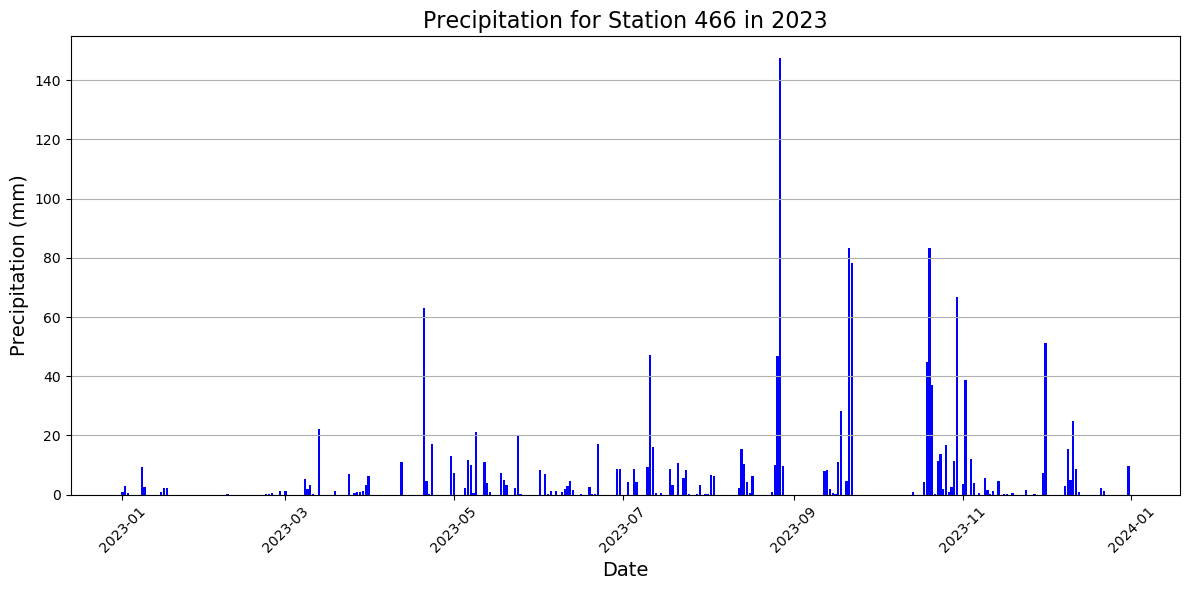

In [18]:
import matplotlib.pyplot as plt

# Filtere die Daten für Station 466 und das Jahr 2023
station_id = 466
year = 2023

# Holen Sie sich die nday-Daten für das Jahr 2023
nday_data = ds['precipitation'].sel(station=station_id)

# Filtere die nday-Daten für das Jahr 2023
nday_data_2023 = nday_data.sel(nday=slice('2023-01-01', '2023-12-31'))

# Plot erstellen
plt.figure(figsize=(12, 6))

# Erstelle ein Balkendiagramm
plt.bar(nday_data_2023['nday'].values, nday_data_2023.values, color='blue', width=0.8)

# Titel und Beschriftungen hinzufügen
plt.title(f'Precipitation for Station {station_id} in {year}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.xticks(rotation=45)  # Drehe die x-Achsen-Beschriftungen für bessere Lesbarkeit
plt.grid(axis='y')  # Optional: Rasterlinien nur für die y-Achse anzeigen
plt.tight_layout()

# Plot anzeigen
plt.show()
